# Analysis of the revisions to 'Quantification of Crypt and Stem Cell Evolution in the Normal and Neoplastic Human Colon' 

In this Jupyter Notebook we shall explore the effects of the revisions to the 'Quantification of Crypt and Stem Cell Evolution in the Normal and Neoplastic Human Colon' paper. These revisions include errors in the process used to correct the data for the spontaneous labelling of adjacent crypts and the inclusion of data from FFPE (rather than the flash-frozen tissue described in the manuscript). 

We show that the inclusion of the FFPE data does not significantly alter the mean fission rates of the patient cohort, whereas the revised correction significantly lowers the estimated mean fission rates (for normal patients the original estimate of the mean fission rate was 0.028 divisions/year/crypt, whilst the revised estimate for these patients is 0.009 divisions/year/crypt)

# Data Sources 

- 'data/Patch_Size_Data_Revisions.csv'

This csv file contains the the patch size data from the 26 patients included in Baker et al., Cell Reports, 2014 along with the age and diagnosis of each patient and the total number of crypts analysed. Whether the samples were flash frozen (instead of FFPE) is also recorded.

# Analysis

In [1]:
# Import relevant python modules

import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import seaborn as sns


We shall define some functions to calculate the fission rate per crypt, apply both the original (incorrect) and revised corrections to the data and print the mean fission rates for the 3 disease groups (Normal, FAP and AFAP).

In [2]:
# Define functions

def patch_size_distribution(b, t, m):
    K_m = (1 - np.exp(-b * t))**m / (b*t*m)
    return K_m


def function_to_min(b, mean_patch_size, t):
    # This function is a rearranged version of d(LL)/db which will
    # minimize the log-likelihood when set to zero

    func = mean_patch_size - (np.exp(b*t) - 1) / (b*t)

    return func

def wrapper_function(mean_patch_size, t):
    # A wrapper function to pass to fsolve (which can only accept 
    # functions that have a single parameter)

    return lambda b:  function_to_min(b, mean_patch_size, t)

def error_on_estimate(b, t, patch_dist):
    # The standard error of a maximum likelihood estimate can be calculated 
    # from the Fisher Information, which in turn can be calculated from 
    # d^2(LL)/db^2.

    patch_size = patch_dist.index.astype(int).values
    sum_m = np.sum(patch_size * patch_dist)
    Npatches = np.sum(patch_dist)

    d2LL_db2 = Npatches/(b**2) + sum_m * (t**2) / (2 - 2*np.cosh(b*t))

    sd = 1 / np.sqrt(- d2LL_db2)

    return sd

def calculate_fission_rate(data):
    # This function calculates the fission rate per crypt for each patient 
    # from data in the form of a pandas array using the above wrapper function

    patch_data = data.loc[:, '1':'15']
    age = data.Ages
    patch = patch_data.columns.values.astype(int)
    
    b_rate = list()
    b_rate_error = list()
    b_initial = 0.01

    for index, t in enumerate(age):
        patch_dist = patch_data.loc[index, :]
        mean_patch_size = sum(patch * patch_dist) / sum(patch_dist)

        f_fission = wrapper_function(mean_patch_size, t)

        fission_rate = fsolve(f_fission, b_initial)[0]
        error = error_on_estimate(fission_rate, t, patch_dist)
        
        b_rate.append(fission_rate)
        b_rate_error.append(error)

    data['fission_rate'] = b_rate
    data['fission_rate_error'] = b_rate_error

    return data


def original_correction(data):
    # The original correction applied to data in the 2014 paper:
    # 'Quantification of Crypt and Stem Cell Evolution in the Normal 
    # and Neoplastic Human Colon'
    
    data = data.copy()
    
    total = data.TotalCrypts

    number_of_patches = np.sum(data.loc[:, '1':'15'], axis = 1)

    # Correct the data for spontaneous mutation of adjacent patches
    mutation_rate = number_of_patches/total

    data['1'] = data['1'] + (mutation_rate)**2*(1-mutation_rate)**6*2*total
    columns = [str(col) for col in range(1, 16)]
    for i in columns:
        data[i] = data[i] - 2 * (mutation_rate)**int(i) * total
        data.loc[data[i] < 0, i] = 0

    data['1'] = 0

    return data

def revised_correction(data):
    # The revised correction in which we do not ignore the singleton crypts
    
    data = data.copy()
    
    total = data.TotalCrypts
    number_of_patches = np.sum(data.loc[:, '1':'15'], axis = 1)

    # Correct the data for spontaneous mutation of adjacent patches
    mutation_rate = number_of_patches/total
    data['1'] = data['1'] + 2 * (mutation_rate)**2 * (1-mutation_rate)**2 * 2 * total
    data['2'] = data['2'] - (mutation_rate)**2 * (1-mutation_rate)**2 * 2 * total
    data.loc[data['2'] < 0, '2'] = 0

    return data

def print_mean_fission_rate(fission_data):
    # A function that prints the mean fission rate of data that has been 
    # passed to the calculate_fission_rate function
    disease = ['Normal', 'FAP', 'AFAP']
    
    for d in disease:
        average = np.mean(fission_data.loc[fission_data['Disease'] == d, 'fission_rate'])
        sd = np.std(fission_data.loc[fission_data['Disease'] == d, 'fission_rate'], ddof=1)
        print('The mean fission rate for {} is {:.2} ± {:.1}'.format(d, average, sd))



First, we shall apply the original correction to the original data included in the 2014 paper

In [3]:
# Load original data from a csv file 
OriginalDataPath = 'data/Patch_Size_Data_Revisions.csv'
OriginalData = pd.read_csv(OriginalDataPath)

OriginalData


,PatientNumber,FlashFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,True,Normal,79,4919,228,71,23,6,3,2,1,0,0,0,0,0,0,0,0
1,2,True,Normal,60,3547,54,1,2,2,0,0,0,0,0,0,0,0,0,0,0
2,3,True,Normal,64,6958,86,6,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,True,FAP,67,6417,106,49,17,4,7,0,0,0,0,0,0,0,0,0,0
4,5,True,FAP,59,4095,40,15,13,8,8,2,0,0,0,0,0,0,0,0,0
5,6,True,FAP,39,3085,29,4,2,0,0,0,0,0,0,0,0,0,0,0,0
6,7,True,AFAP,64,11313,143,64,17,2,2,0,2,0,1,0,1,0,0,0,0
7,8,True,AFAP,65,11755,86,39,11,4,0,0,0,0,0,0,0,0,0,0,0
8,9,True,AFAP,61,4174,65,37,20,10,1,0,2,3,0,0,0,0,0,0,0
9,14,True,Normal,42,2702,20,6,0,1,0,1,0,0,0,0,0,0,0,0,0


In [4]:
OriginalData_OriginalCorrections = original_correction(OriginalData)

OriginalData_OriginalCorrections_fission = calculate_fission_rate(OriginalData_OriginalCorrections)

round_dict = {key:1 for key in OriginalData.columns[5:] }

OriginalData_OriginalCorrections_fission.round(round_dict)

,PatientNumber,FlashFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,0,25.6,19.9,5.8,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023653,0.002840
1,2,True,Normal,60,3547,0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035664,0.014999
2,3,True,Normal,64,6958,0,3.5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022262,0.011236
3,4,True,FAP,67,6417,0,38.6,16.7,4.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025882,0.003024
4,5,True,FAP,59,4095,0,11.4,12.9,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035797,0.004647
5,6,True,FAP,39,3085,0,3.2,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039548,0.017688
6,7,True,AFAP,64,11313,0,54.5,16.8,2.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.026879,0.002884
7,8,True,AFAP,65,11755,0,35.7,11.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023639,0.003395
8,9,True,AFAP,61,4174,0,27.9,19.7,10.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032131,0.003560
9,14,True,Normal,42,2702,0,5.4,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042901,0.014637


In [5]:
# Print the mean fission rate of the original data
print('Original data with the incorrect correction applied:\n')
print_mean_fission_rate(OriginalData_OriginalCorrections_fission)

Original data with the incorrect correction applied:

The mean fission rate for Normal is 0.028 ± 0.007
The mean fission rate for FAP is 0.034 ± 0.007
The mean fission rate for AFAP is 0.028 ± 0.004


The data must be corrected for the possibility of neighbouring crypts being spontaneously labelled (but not clonally related). In the calculation performed in the 2014 paper, the number of singleton crypts were set 0, as these were not seen to be relevant to the rate at which fission occurs. However, the number of singleton crypts is important, as it serves to normalize the number of fission events that have occured to the number of labelled crypts. The original paper also contained an error in the equation for the number of patches of size 2 (the factor $\frac{\zeta}{2}$ should multiply rather than divide the other terms). The probabilty that two neighboring crypts are clonally marked by chance is given by: $$p^2 (1-p)^{\zeta - 2} \frac{\zeta}{2}$$
Below we perform a quick simulation to confirm this.

In [6]:
# A simulation to confirm the form of the revised correction 
runs = 100
p = 0.01
N = 1000
number_of_crypts = N ** 2
number_of_neighbours = 4

simulation = np.zeros((runs, 1))
for i in range(runs):
    # Generate a matrix containing number_of_crypts crypts with each crypt having a probability p of being labelled
    simulation_matrix = np.random.choice((True, False), size=(N, N), p=(p, 1-p))
    labels = label(simulation_matrix, number_of_neighbours)

    stats = regionprops(labels)
    area = [r.area for r in stats]

    # Count the number of patches of size 2
    num_adjacent_sim = area.count(2)
    simulation[i] = num_adjacent_sim
    
mean_sim = np.mean(simulation)
std_sim = np.std(simulation)

mutation_rate = len(area)/number_of_crypts
num_adjacent_predict = (mutation_rate)**2 * (1-mutation_rate)**(number_of_neighbours - 2) * (number_of_neighbours / 2) * number_of_crypts

print('The predicted number of patches of size 2 due to spontaneous labelling is {:.1f}'.format(num_adjacent_predict))
print('The mean number of patches of size 2 in the simulation is {:.1f} with standard deviation {:.1f}'.format(mean_sim, std_sim))

relative_error = abs(num_adjacent_predict - mean_sim) / num_adjacent_predict

print('The relative error is {:.1}'.format(relative_error))

The predicted number of patches of size 2 due to spontaneous labelling is 191.6
The mean number of patches of size 2 in the simulation is 188.6 with standard deviation 12.6
The relative error is 0.02


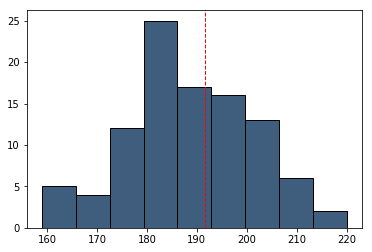

In [7]:
h = plt.hist(simulation, 9,  edgecolor='k', color="#3F5D7D")
l = plt.axvline(num_adjacent_predict, color='r', linestyle='dashed', linewidth=1)


As we can see, the revised correction well predicts the number of patches of size two due to the spontaneous labelling of neighbouring crypts. We shall now repeat the analysis but applying the appropriate correction (assuming that each crypt has 4 neighbours).


In [8]:
OriginalData_RevisedCorrections = revised_correction(OriginalData)

OriginalData_RevisedCorrections_fission = calculate_fission_rate(OriginalData_RevisedCorrections)

OriginalData_RevisedCorrections_fission.round(round_dict)

,PatientNumber,FlashFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,306.8,31.6,23,6,3,...,0,0,0,0,0,0,0,0,0.006924,0.000656
1,2,True,Normal,60,3547,57.8,0.0,2,2,0,...,0,0,0,0,0,0,0,0,0.004881,0.001584
2,3,True,Normal,64,6958,90.8,3.6,1,0,0,...,0,0,0,0,0,0,0,0,0.001759,0.000752
3,4,True,FAP,67,6417,125.7,39.1,17,4,7,...,0,0,0,0,0,0,0,0,0.012863,0.001320
4,5,True,FAP,59,4095,46.9,11.5,13,8,8,...,0,0,0,0,0,0,0,0,0.023411,0.002693
5,6,True,FAP,39,3085,30.6,3.2,2,0,0,...,0,0,0,0,0,0,0,0,0.009159,0.003520
6,7,True,AFAP,64,11313,161.3,54.9,17,2,2,...,0,1,0,1,0,0,0,0,0.012842,0.001211
7,8,True,AFAP,65,11755,92.5,35.7,11,4,0,...,0,0,0,0,0,0,0,0,0.011493,0.001482
8,9,True,AFAP,61,4174,82.1,28.5,20,10,1,...,3,0,0,0,0,0,0,0,0.019545,0.001914
9,14,True,Normal,42,2702,21.1,5.4,0,1,0,...,0,0,0,0,0,0,0,0,0.017307,0.005075


In [9]:
# Print the mean fission rate of the original data
print('Original data with the correct correction applied:\n')
print_mean_fission_rate(OriginalData_RevisedCorrections_fission)

Original data with the correct correction applied:

The mean fission rate for Normal is 0.011 ± 0.007
The mean fission rate for FAP is 0.015 ± 0.007
The mean fission rate for AFAP is 0.015 ± 0.004


The data included in the 2014 paper included several Formalin-Fixed Paraffin-Embedded (FFPE) tissue rather than flash-frozen. The enzyme histochemistry techniques described in the manuscript are not effective on FFPE tissue, so an alternative immunohistochemical approach was taken for these samples. Whilst it is is likely that these different approaches yield similar staining results, for consistency we explore the effect of excluding these samples from the analysis. We shall now re-run the analysis on the original data for comparison, and finally on the revised dataset. 


In [10]:
RevisedData = OriginalData.loc[OriginalData['FlashFrozen'], :]
RevisedData.reset_index(inplace=True)
RevisedData = RevisedData.drop(columns = 'index')

RevisedData_OriginalCorrections = original_correction(RevisedData)

RevisedData_OriginalCorrections_fission = calculate_fission_rate(RevisedData_OriginalCorrections)

RevisedData_OriginalCorrections_fission.round(round_dict)

,PatientNumber,FlashFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,0,25.6,19.9,5.8,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023653,0.002840
1,2,True,Normal,60,3547,0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035664,0.014999
2,3,True,Normal,64,6958,0,3.5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022262,0.011236
3,4,True,FAP,67,6417,0,38.6,16.7,4.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025882,0.003024
4,5,True,FAP,59,4095,0,11.4,12.9,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035797,0.004647
5,6,True,FAP,39,3085,0,3.2,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039548,0.017688
6,7,True,AFAP,64,11313,0,54.5,16.8,2.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.026879,0.002884
7,8,True,AFAP,65,11755,0,35.7,11.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023639,0.003395
8,9,True,AFAP,61,4174,0,27.9,19.7,10.0,1.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032131,0.003560
9,14,True,Normal,42,2702,0,5.4,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042901,0.014637


In [11]:
# Print the mean fission rate of the original data
print('Revised data with the incorrect correction applied:\n')
print_mean_fission_rate(RevisedData_OriginalCorrections_fission)

Revised data with the incorrect correction applied:

The mean fission rate for Normal is 0.027 ± 0.007
The mean fission rate for FAP is 0.034 ± 0.007
The mean fission rate for AFAP is 0.028 ± 0.004


And finally we apply the appropriate correction to the revised data.

In [12]:
RevisedData_RevisedCorrections = revised_correction(RevisedData)

RevisedData_RevisedCorrections_fission = calculate_fission_rate(RevisedData_RevisedCorrections)

RevisedData_RevisedCorrections_fission.round(round_dict)

,PatientNumber,FlashFrozen,Disease,Ages,TotalCrypts,1,2,3,4,5,...,8,9,10,11,12,13,14,15,fission_rate,fission_rate_error
0,1,True,Normal,79,4919,306.8,31.6,23,6,3,...,0,0,0,0,0,0,0,0,0.006924,0.000656
1,2,True,Normal,60,3547,57.8,0.0,2,2,0,...,0,0,0,0,0,0,0,0,0.004881,0.001584
2,3,True,Normal,64,6958,90.8,3.6,1,0,0,...,0,0,0,0,0,0,0,0,0.001759,0.000752
3,4,True,FAP,67,6417,125.7,39.1,17,4,7,...,0,0,0,0,0,0,0,0,0.012863,0.001320
4,5,True,FAP,59,4095,46.9,11.5,13,8,8,...,0,0,0,0,0,0,0,0,0.023411,0.002693
5,6,True,FAP,39,3085,30.6,3.2,2,0,0,...,0,0,0,0,0,0,0,0,0.009159,0.003520
6,7,True,AFAP,64,11313,161.3,54.9,17,2,2,...,0,1,0,1,0,0,0,0,0.012842,0.001211
7,8,True,AFAP,65,11755,92.5,35.7,11,4,0,...,0,0,0,0,0,0,0,0,0.011493,0.001482
8,9,True,AFAP,61,4174,82.1,28.5,20,10,1,...,3,0,0,0,0,0,0,0,0.019545,0.001914
9,14,True,Normal,42,2702,21.1,5.4,0,1,0,...,0,0,0,0,0,0,0,0,0.017307,0.005075


In [13]:
# Print the mean fission rate of the original data
print('Revised data with the correct correction applied:\n')
print_mean_fission_rate(RevisedData_RevisedCorrections_fission)

Revised data with the correct correction applied:

The mean fission rate for Normal is 0.0089 ± 0.005
The mean fission rate for FAP is 0.015 ± 0.007
The mean fission rate for AFAP is 0.015 ± 0.004


The revised correction yields significantly lower mean fission rates across all three patient cohorts. 

The original correction applied to the data ignores the patches of size 1, so as a consistency check we can compare the number of singleton crypts predicted by the patch size distribution using the fission rates estimated from the model with the actual number of observed singleton crypts.

In [14]:
OriginalFissionRate = RevisedData_OriginalCorrections_fission['fission_rate']
ProbabilityPatchOne = patch_size_distribution(OriginalFissionRate, RevisedData['Ages'], 1)
Number_of_patches = np.sum(RevisedData.loc[:, '1':'15'], 1)
ExpectationPatchOne = ProbabilityPatchOne * Number_of_patches
Fraction_CCO = Number_of_patches/RevisedData['TotalCrypts']
FoldChange = RevisedData['1'] / ExpectationPatchOne
RevisedData_Expectation = pd.DataFrame({'PatientNumber':RevisedData['PatientNumber'], 'FlashFrozen':RevisedData['FlashFrozen'],
                                        'FractionCCODeficient':Fraction_CCO, 'ActualPatchOne':RevisedData['1'], 
                                        'ExpectationPatchOne':ExpectationPatchOne, 'FoldChange': FoldChange}, 
                                      columns=['PatientNumber', 'FractionCCODeficient', 'ActualPatchOne', 
                                               'ExpectationPatchOne', 'FoldChange'])

In [15]:
RevisedData_Expectation.round({'FractionCCODeficient':3, 'FoldChange':2}).astype({'ExpectationPatchOne':int})

,PatientNumber,FractionCCODeficient,ActualPatchOne,ExpectationPatchOne,FoldChange
0,1,0.068,228,151,1.51
1,2,0.017,54,24,2.22
2,3,0.013,86,49,1.73
3,4,0.029,106,86,1.22
4,5,0.021,40,35,1.12
5,6,0.011,29,17,1.63
6,7,0.021,143,110,1.29
7,8,0.012,86,71,1.20
8,9,0.033,65,60,1.07
9,14,0.010,20,12,1.54


In [16]:
MeanFoldChange = np.mean(FoldChange)
print('The mean fold-change is {:.3}'.format(MeanFoldChange))

The mean fold-change is 1.48


The original approach underestimates the number of singleton crypts in 19/20 samples.

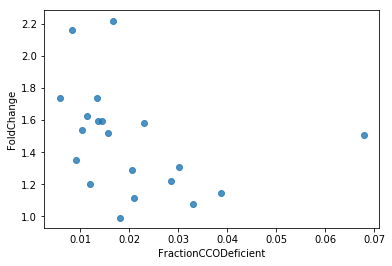

In [17]:
ax = sns.regplot(x='FractionCCODeficient', y='FoldChange', data=RevisedData_Expectation, fit_reg=False)

There appears to be no correlation between the fraction of CCO deficient crypts and the degree to which the original method overestimates the number of singleton crypts.